In [1]:
import sys
sys.path.append('..')
from itertools import product
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt 
from functools import lru_cache
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator


In [2]:
# Loading my modules
from physics_informed_vector_fields.current_carrying_coil import field_around_current_carrying_coil

from plotting_tools.plotter import plotter, cross_section_plotter
from plotting_tools.field_comparison import differencer
from plotting_tools.sample_field import sample_field

from GP_Implementation.Kernel import sample_vector_field

In [3]:
outputs_wire = field_around_current_carrying_coil(100000000, resolution=30)
#test_outputs = sample_vector_field(kernel_func='divergence_free_kernel')
plotter(outputs_wire, 
        title = 'B fields around current carrying wire')

In [4]:
# unpack outputs
x, y, z = outputs_wire[0], outputs_wire[1], outputs_wire[2]
u, v, w = outputs_wire[3], outputs_wire[4], outputs_wire[5]

In [5]:
field_magnitude = np.zeros_like(v)
field_magnitude = np.sqrt(u**2 + v**2 +w**2)

In [6]:
u_norm, v_norm, w_norm = u/field_magnitude, v/field_magnitude, w/field_magnitude 

In [7]:
plotter([x, y, z, u_norm, v_norm, w_norm],
        title = 'B fields around current carrying wire')

In [8]:
def compute_jacobian(field, dx):
    """
    field: shape (Nx, Ny, Nz, 3) — 3D vector field
    dx:    float or 3-tuple of spacing(s)
    
    Returns
    -------
    jacobian: shape (Nx, Ny, Nz, 3, 3)
       jacobian[i, j, k] is the 3×3 matrix of partial derivatives
       at (i, j, k). Rows are partial wrt x, y, z; columns are B_x, B_y, B_z.
    """
    grads = [np.gradient(field[..., i], *( [dx]*3 ), edge_order=1)
             for i in range(3)]  # each grads[i] is a list [∂/∂x of B_i, ∂/∂y of B_i, ∂/∂z of B_i]

    # Stack into shape: (3, 3, Nx, Ny, Nz)
    jacobian = np.array(grads)
    # Transpose to shape: (Nx, Ny, Nz, 3, 3)
    jacobian = np.transpose(jacobian, (2, 3, 4, 0, 1))

    return jacobian

def distortion_by_axis(jacobian):
    """
    Computes the per-axis 'distortion'. For each voxel, we look at the 3×3 
    Jacobian matrix and sum squares across each row, giving a shape (Nx, Ny, Nz, 3).

    If the Jacobian at a point is:
       [[∂Bx/∂x, ∂By/∂x, ∂Bz/∂x],
        [∂Bx/∂y, ∂By/∂y, ∂Bz/∂y],
        [∂Bx/∂z, ∂By/∂z, ∂Bz/∂z]],
    then for row i, we do:
       distortion[i] = sqrt( (∂Bx/∂i)^2 + (∂By/∂i)^2 + (∂Bz/∂i)^2 ).

    Returns
    -------
    dist: shape (Nx, Ny, Nz, 3)
          dist[...,0] is the x-distortion, 
          dist[...,1] is the y-distortion, 
          dist[...,2] is the z-distortion.
    """
    # Sum squares across columns (the last axis = -1)
    rowwise_sums = np.sum(jacobian**2, axis=-1)  
    # Take square root to get distortion
    dist = rowwise_sums
    return dist


In [9]:
field = np.stack([u_norm, v_norm, w_norm], axis=-1)  # shape: (Nx, Ny, Nz, 3)
matrix = compute_jacobian(field, dx=1)
matrix.shape

(30, 30, 30, 3, 3)

In [10]:
scalar_function = distortion_by_axis(matrix)
scalar_function.shape

(30, 30, 30, 3)

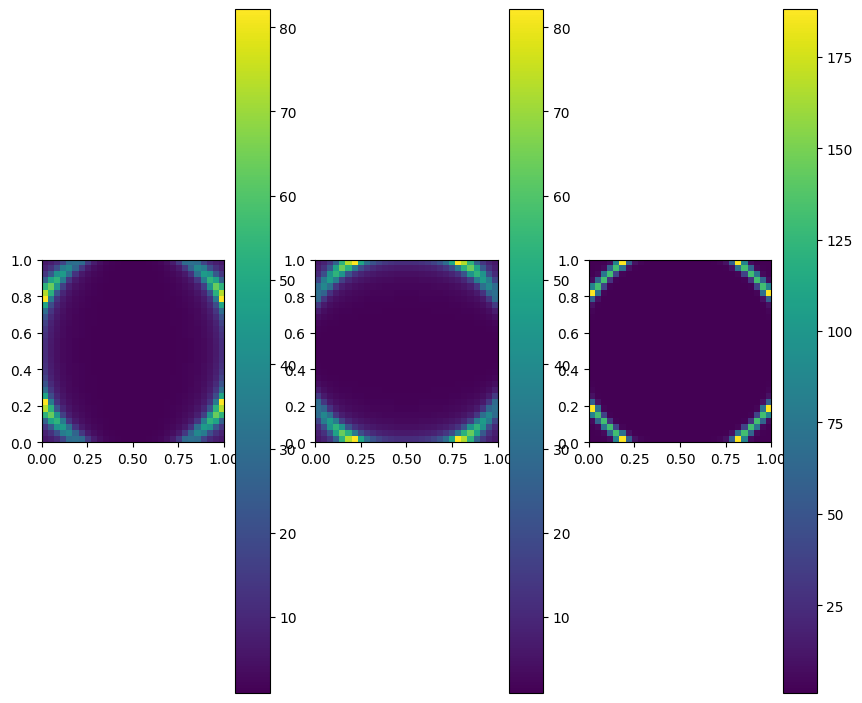

In [11]:
scalar_function = scalar_function + 0.01
scalar_function = scalar_function 
z_index = scalar_function.shape[2] // 2

slice_2d_x_dist = scalar_function[:, :, z_index, 0] / np.min(scalar_function[:, :, z_index, 0])
slice_2d_y_dist = scalar_function[:, :, z_index, 1] / np.min(scalar_function[:, :, z_index, 1])
slice_2d_z_dist = scalar_function[:, :, z_index, 2] / np.min(scalar_function[:, :, z_index, 2])

fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# Plot each slice and store the result in imX
im0 = axes[0].imshow(slice_2d_x_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
im1 = axes[1].imshow(slice_2d_y_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
im2 = axes[2].imshow(slice_2d_z_dist.T, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])

fig.colorbar(im0, ax=axes[0], orientation='vertical')
fig.colorbar(im1, ax=axes[1], orientation='vertical')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.show()


In [12]:
np.max(slice_2d_x_dist)

np.float64(82.14146876333642)

In [13]:
# Define physical grid — adjust to your domain
x = np.linspace(-1/2, 1/2, 30)
y = np.linspace(-1/2, 1/2, 30)
z = np.linspace(-1/2, 1/2, 30)

scalar_function_x = scalar_function[:, :, :,0] / np.min(scalar_function[:, :, :,0])
scalar_function_y = scalar_function[:, :, :,1] / np.min(scalar_function[:, :, :,1])
scalar_function_z = scalar_function[:, :, :,2] / np.min(scalar_function[:, :, :,2])

interp_variation_x = RegularGridInterpolator((x, y, z), scalar_function_x, bounds_error=False, fill_value=None)
interp_variation_y = RegularGridInterpolator((x, y, z), scalar_function_y, bounds_error=False, fill_value=None)
interp_variation_z = RegularGridInterpolator((x, y, z), scalar_function_z, bounds_error=False, fill_value=None)



In [14]:
@lru_cache(maxsize=None)
def warp_coordinate(
    coords_3d,
    interp_alpha = [interp_variation_x, interp_variation_y, interp_variation_z],
    axis_points=50
):
    """
    Warp a single 3D point using line integrals along each axis from the origin.

    Args:
        coords_3d: (3,) array-like
        interp_alpha: list of 3 interpolator functions
                      [interp_variation_x, interp_variation_y, interp_variation_z]
        axis_points: number of steps for integration (not currently used by quad, 
                     but you could pass "limit=axis_points" to quad if you want).

    Returns:
        x_prime: (3,) warped coordinate
    """
    x = np.asarray(coords_3d, dtype=float)
    x_prime = np.zeros_like(x)
    val_multiplier = 1
    for i in range(3):
        # Integrate along axis i from 0 to x[i], holding other coords fixed
        def integrand(t):
            # create a copy of x so we can vary only the i-th coordinate
            pt = np.zeros_like(x)  # <-- this is the fix: start from the origin
            pt[i] = t              # vary only the i-th axis
            return float(interp_alpha[i](pt)[0])

        # If x[i] < 0, flip integration bounds
        start, end = 0, x[i]
        # if x[i] < 0:
        #     start, end = x[i], 0
        #     val_multiplier = -1
        val, _ = quad(integrand, start, end)  # you can add limit=axis_points if needed
        x_prime[i] = val 
    
    return x_prime



In [15]:
pt = [0.001, -1, 2]
warped_pt = warp_coordinate(tuple(pt))
print("Original:", pt)
print("Warped:", warped_pt)


Original: [0.001, -1, 2]
Warped: [ 1.00000000e-03 -2.40741131e+01  2.00076436e+00]


C:\Users\ellinghh\AppData\Local\Temp\ipykernel_15756\2477574158.py:36: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



In [16]:
def divergence_free_kernel(x1:np.array, x2:np.array, sigma_f:float =1, l:float=1)->np.ndarray:
    '''
    Should be a divergence free vector field which you get from here. There surely arent that 
    many of these, so this will hopefully quickly look like a magnetic field. 

    formula 2.48
    '''
    
    # if np.any((np.sqrt(x1[0]**2+x1[1]**2) < 0.2) and (np.sqrt(x2[0]**2+x2[1]**2) < 0.2)):
    #     l = 0.2
    # elif (np.sqrt(x1[0]**2+x1[1]**2) < 0.2) or (np.sqrt(x2[0]**2+x2[1]**2) < 0.2):
    #     return np.zeros((3,3))
    # else:
    #     l = 1
    diff = x1 - x2
    # def some distance measure
    r2 = np.dot(diff, diff)
    term1 = (2 - r2 / l**2) * np.eye(len(x1))
    term2 = np.outer(diff, diff) / l**2
    scaling = np.exp(- r2 / (2 * l**2)) * (sigma_f / l)**2
    K = (term1 + term2) * scaling
    return K


In [17]:
def updated_vector_field(inputs:list[np.ndarray],
                         grid_x: np.ndarray, grid_y: np.ndarray, grid_z: np.ndarray,
                         sigma_f = None, l = None,
                         random_seed: int = 1, 
                         noise:float = 1e-6):
    """
    Compute the GP-posterior vector field given noisy vector observations at a few points.
    returns a 3D vector field evaluated over the entire grid, conditioned on known field measurements.
    """
    sampled_points_x, sampled_points_y, sampled_points_z = inputs[0], inputs[1], inputs[2]
    sampled_fields_x, sampled_fields_y, sampled_fields_z = inputs[3], inputs[4], inputs[5]
    np.random.seed(random_seed)

    # Choose kernel

    function_chosen = divergence_free_kernel  

    # this allows us to loop over these points
    points = np.vstack([grid_x.flatten(), grid_y.flatten(), grid_z.flatten()]).T               # (N, 3)
    points_sampled = np.vstack([sampled_points_x.flatten(), sampled_points_y.flatten(), sampled_points_z.flatten()]).T  # (M, 3)
    fields_sampled = np.vstack([sampled_fields_x.flatten(), sampled_fields_y.flatten(), sampled_fields_z.flatten()]).T  # (M, 3)

    N = points.shape[0]           # number of grid points
    M = points_sampled.shape[0]   # number of observations
    D = 3                         # vector field dimensionality

    # Allocate covariance matrices
    K_x_x = np.zeros((M * D, M * D))        # covariance between sampled points
    K_xstar_x = np.zeros((N * D, M * D))    # covariance between grid and sampled
    K_xstar_xstar = np.zeros((N * D, N * D))  # covariance between grid points
    # also our observations vector 
    y = np.zeros(M * D)

    # Build K_x_x
    for i in tqdm(range(M)):#, desc="Loop 0", position=0, leave=True):
        for j in range(M):
            x1_transformed = warp_coordinate(tuple(points_sampled[i]))
            x2_transformed = warp_coordinate(tuple(points_sampled[j]))
            K_ij = function_chosen(x1_transformed, x2_transformed, sigma_f=sigma_f, l=l)  # (3x3)
            K_x_x[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 1 populated')

    # Build K_xstar_x
    for i in tqdm(range(N)):
        for j in range(M):
            x1_transformed = warp_coordinate(tuple(points[i]))
            x2_transformed = warp_coordinate(tuple(points_sampled[j]))
            K_ij = function_chosen(points[i], points_sampled[j], sigma_f=sigma_f, l=l)  # (3x3)
            K_xstar_x[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 2 populated')

    # Build K_xstar_xstar
    for i in tqdm(range(N)):
        for j in range(N):
            x1_transformed = warp_coordinate(tuple(points[i]))
            x2_transformed = warp_coordinate(tuple(points[j]))
            K_ij = function_chosen(points[i], points[j], sigma_f=sigma_f, l=l)  # (3x3)
            K_xstar_xstar[i*D:(i+1)*D, j*D:(j+1)*D] = K_ij
    print('matrix 3 populated')

    # Build y
    for i in range(M):
        y[i*D:(i+1)*D] = fields_sampled[i]  # (3x,)?
    print('matrix 4 populated')

    # GP posterior mean and cov sampled
    K_x_x = K_x_x + noise * np.eye(M * D)
    print('initialising solver')
    posterior_mean = K_xstar_x @ np.linalg.solve(K_x_x, y)
    posterior_covar = K_xstar_xstar - K_xstar_x @ np.linalg.solve(K_x_x, K_xstar_x.T)
    # sample = np.random.multivariate_normal(posterior_mean, posterior_covar)

    # Reshape into 3D vector field
    field_vectors = posterior_mean.reshape(N, D)
    U = field_vectors[:, 0].reshape(grid_x.shape)
    V = field_vectors[:, 1].reshape(grid_y.shape)
    W = field_vectors[:, 2].reshape(grid_z.shape)

    return grid_x, grid_y, grid_z, U, V, W

In [18]:
sparse_outputs_wire = field_around_current_carrying_coil(100000000, resolution=10)

sampled_outputs_wire = sample_field(sparse_outputs_wire, n_samples=250, random_seed=1)


In [ ]:
plotter(sampled_outputs_wire, 
        title = 'Points given to our GP Regressor for current carrying wire')

In [21]:
outputs_coil_div_free= updated_vector_field(
    sampled_outputs_wire, 
    sparse_outputs_wire[0], sparse_outputs_wire[1], sparse_outputs_wire[2], 
    sigma_f= 0.00008, l = 0.26)

100%|██████████| 250/250 [00:00<00:00, 297.49it/s]


matrix 1 populated


 17%|█▋        | 167/1000 [00:00<00:03, 223.02it/s]C:\Users\ellinghh\AppData\Local\Temp\ipykernel_15756\2477574158.py:36: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

C:\Users\ellinghh\AppData\Local\Temp\ipykernel_15756\2477574158.py:36: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

100%|██████████| 1000/1000 [09:32<00:00,  1.75it/s]   


matrix 2 populated


100%|██████████| 1000/1000 [00:17<00:00, 56.39it/s]


matrix 3 populated
matrix 4 populated
initialising solver


In [22]:
given_samples_wire = sampled_outputs_wire[0].shape[0]
plotter(outputs_coil_div_free, 
        title = f'Div free output from GP Regression for n = {given_samples_wire} input vectors for current carrying wire')

In [23]:
residuals_wire_div_free, mse_wire_div_free = differencer(outputs_coil_div_free, sparse_outputs_wire)
print(f'MSE for this case of {mse_wire_div_free}')
plotter(residuals_wire_div_free, 
        title = f'Div free regression errors for n = {given_samples_wire} input vectors for current carrying wire')

MSE for this case of 13.427980853951667


In [24]:
# grid search time 
sigmas = [0.00015, 0.00010, 0.00008, 0.00005, 0.00003, 0.00001]
ls = [0.3, 0.28, 0.26, 0.24, 0.22, 0.2]
for sigma, l in product(sigmas, ls):
    outputs_wire_div_free= updated_vector_field(
        sampled_outputs_wire, 
        sparse_outputs_wire[0], sparse_outputs_wire[1], sparse_outputs_wire[2], 
        sigma_f= sigma, l = l)
    _, mse_wire_div_free = differencer(outputs_wire_div_free, sparse_outputs_wire)
    print(f'for sigma = {sigma}, l = {l}, mse is {mse_wire_div_free}')

100%|██████████| 250/250 [00:00<00:00, 259.75it/s]


matrix 1 populated


 44%|████▍     | 444/1000 [00:01<00:02, 238.37it/s]


KeyboardInterrupt: 

In [ ]:
values = np.linspace(0, 0.5, 50)
transformed_values = [warp_coordinate(tuple([val, 0, 0]))[0] for val in values]

In [ ]:
plt.scatter(values, transformed_values)

In [ ]:
transformed_values